# Analysis of the `iqs2` dataset  


We'll now use from original BEST paper

Data taken from `BESTexample-original.R` in `BEST.zip`
via https://web.archive.org/web/20170708173718/https://www.indiana.edu/~kruschke/BEST/

Steps following Matti Vuorre's [blog post](https://mvuorre.github.io/posts/2017-01-02-how-to-compare-two-groups-with-robust-bayesian-estimation-using-r-stan-and-brms/) see also [src](https://github.com/mvuorre/mvuorre.github.io/tree/main/posts/2017-01-02-how-to-compare-two-groups-with-robust-bayesian-estimation-using-r-stan-and-brms) notebook.

In [1]:
import arviz as az
import numpy as np
import pandas as pd
import seaborn as sns

### Data

In [2]:
iqs2 = pd.read_csv("../../datasets/exercises/iqs2.csv")
iqs2.groupby("group").describe()

iq                                                        
      count        mean       std   min    25%    50%    75%    max
group                                                              
ctrl   42.0  100.357143  2.516496  88.0  100.0  100.5  101.0  105.0
treat  47.0  101.914894  6.021085  82.0  100.0  102.0  103.0  124.0

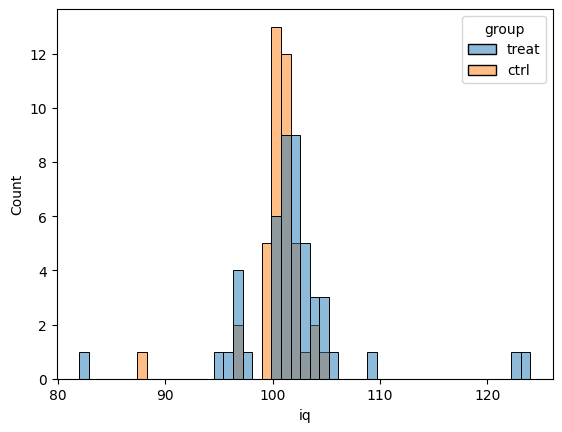

In [3]:
sns.histplot(data=iqs2, x="iq", hue="group");

### BEST model 1: un-shifted exponential prior on nu

In [4]:
import bambi as bmb
import pymc as pm

#######################################################
formula1 = bmb.Formula("iq ~ 0 + group",
                       "sigma ~ 0 + group")

iqs_mean, iqs_std = iqs2["iq"].mean(), iqs2["iq"].std()
sigma_low = np.log(iqs_std / 1000)
sigma_up = np.log(iqs_std * 1000)

priors1 = {
    "group": bmb.Prior("Normal", mu=iqs_mean, sigma=1000*iqs_std),
    "sigma": {"group": bmb.Prior("Uniform", lower=sigma_low, upper=sigma_up)},
    "nu": bmb.Prior("Exponential", lam=1/29),
}


# Build model
mod1 = bmb.Model(formula=formula1,
                 family="t",
                 priors=priors1,
                 data=iqs2)
mod1

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


       Formula: iq ~ 0 + group
                sigma ~ 0 + group
        Family: t
          Link: mu = identity
                sigma = log
  Observations: 89
        Priors: 
    target = mu
        Common-level effects
            group ~ Normal(mu: 101.1798, sigma: 4744.7622)
        
        Auxiliary parameters
            nu ~ Exponential(lam: 0.0345)
    target = sigma
        Common-level effects
            sigma_group ~ Uniform(lower: -5.3507, upper: 8.4648)

In [5]:
mod1.build()
mod1.backend.model

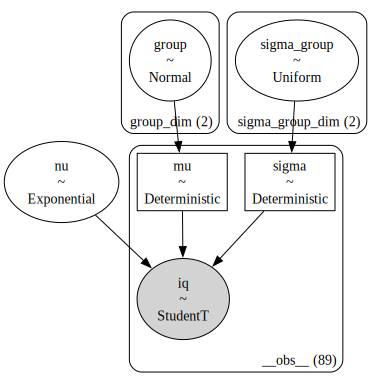

In [6]:
mod1.graph()

In [7]:
idata1 = mod1.fit(draws=10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, group, sigma_group]


Output()

Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 4 seconds.


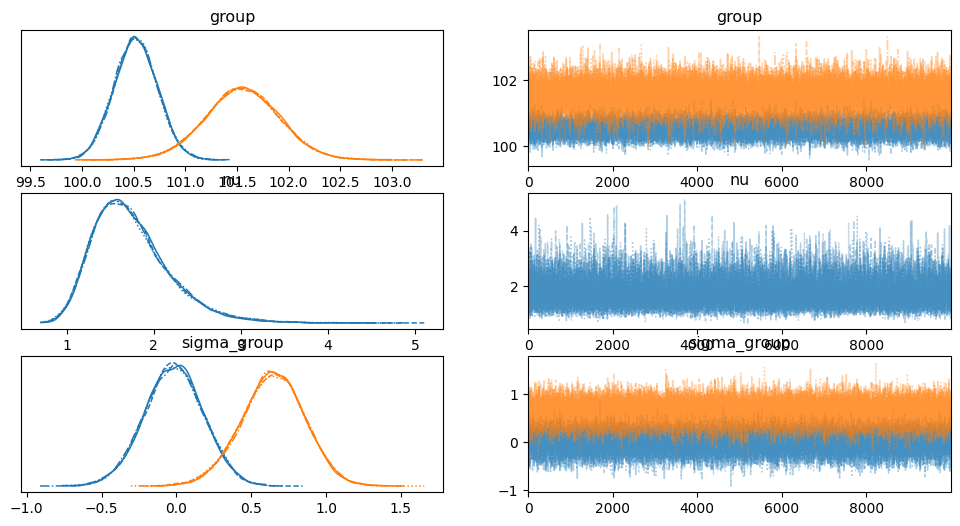

In [8]:
az.plot_trace(idata1);

In [9]:
# Calculate relevant quantities

# Difference posterior of the difference between means
post1 = idata1["posterior"]

post1_dmeans = post1["group"][:,:,1] - post1["group"][:,:,0]
# ALT. post1["group"].sel(group_dim="treat") - post1["group"].sel(group_dim="ctrl")
post1["dmeans"] = post1_dmeans

# Sigmas from log-sigmas
post1["sigma_treat"] = np.exp(post1["sigma_group"][:,:,1])
post1["sigma_ctrl"] = np.exp(post1["sigma_group"][:,:,0])

# # log-nu from nu
post1["log_nu"] = np.log10(post1["nu"])

# Difference in standard deviations
post1["dstd"] = post1["sigma_treat"] - post1["sigma_ctrl"]

# Effect size
var_pooled = (post1["sigma_treat"]**2 + post1["sigma_ctrl"]**2) / 2
post1["cohend"] = post1["dmeans"] / np.sqrt(var_pooled)

In [10]:
import arviz as az
az.summary(idata1, kind="stats", hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%
group[ctrl],100.522,0.210,100.103,100.921
group[treat],101.551,0.364,100.856,102.287
nu,1.744,0.450,0.958,2.623
sigma_group[ctrl],-0.019,0.197,-0.405,0.366
sigma_group[treat],0.644,0.212,0.225,1.055
dmeans,1.030,0.420,0.201,1.849
sigma_treat,1.948,0.414,1.193,2.775
sigma_ctrl,1.001,0.198,0.632,1.393
log_nu,0.228,0.107,0.024,0.443
dstd,0.947,0.419,0.169,1.801


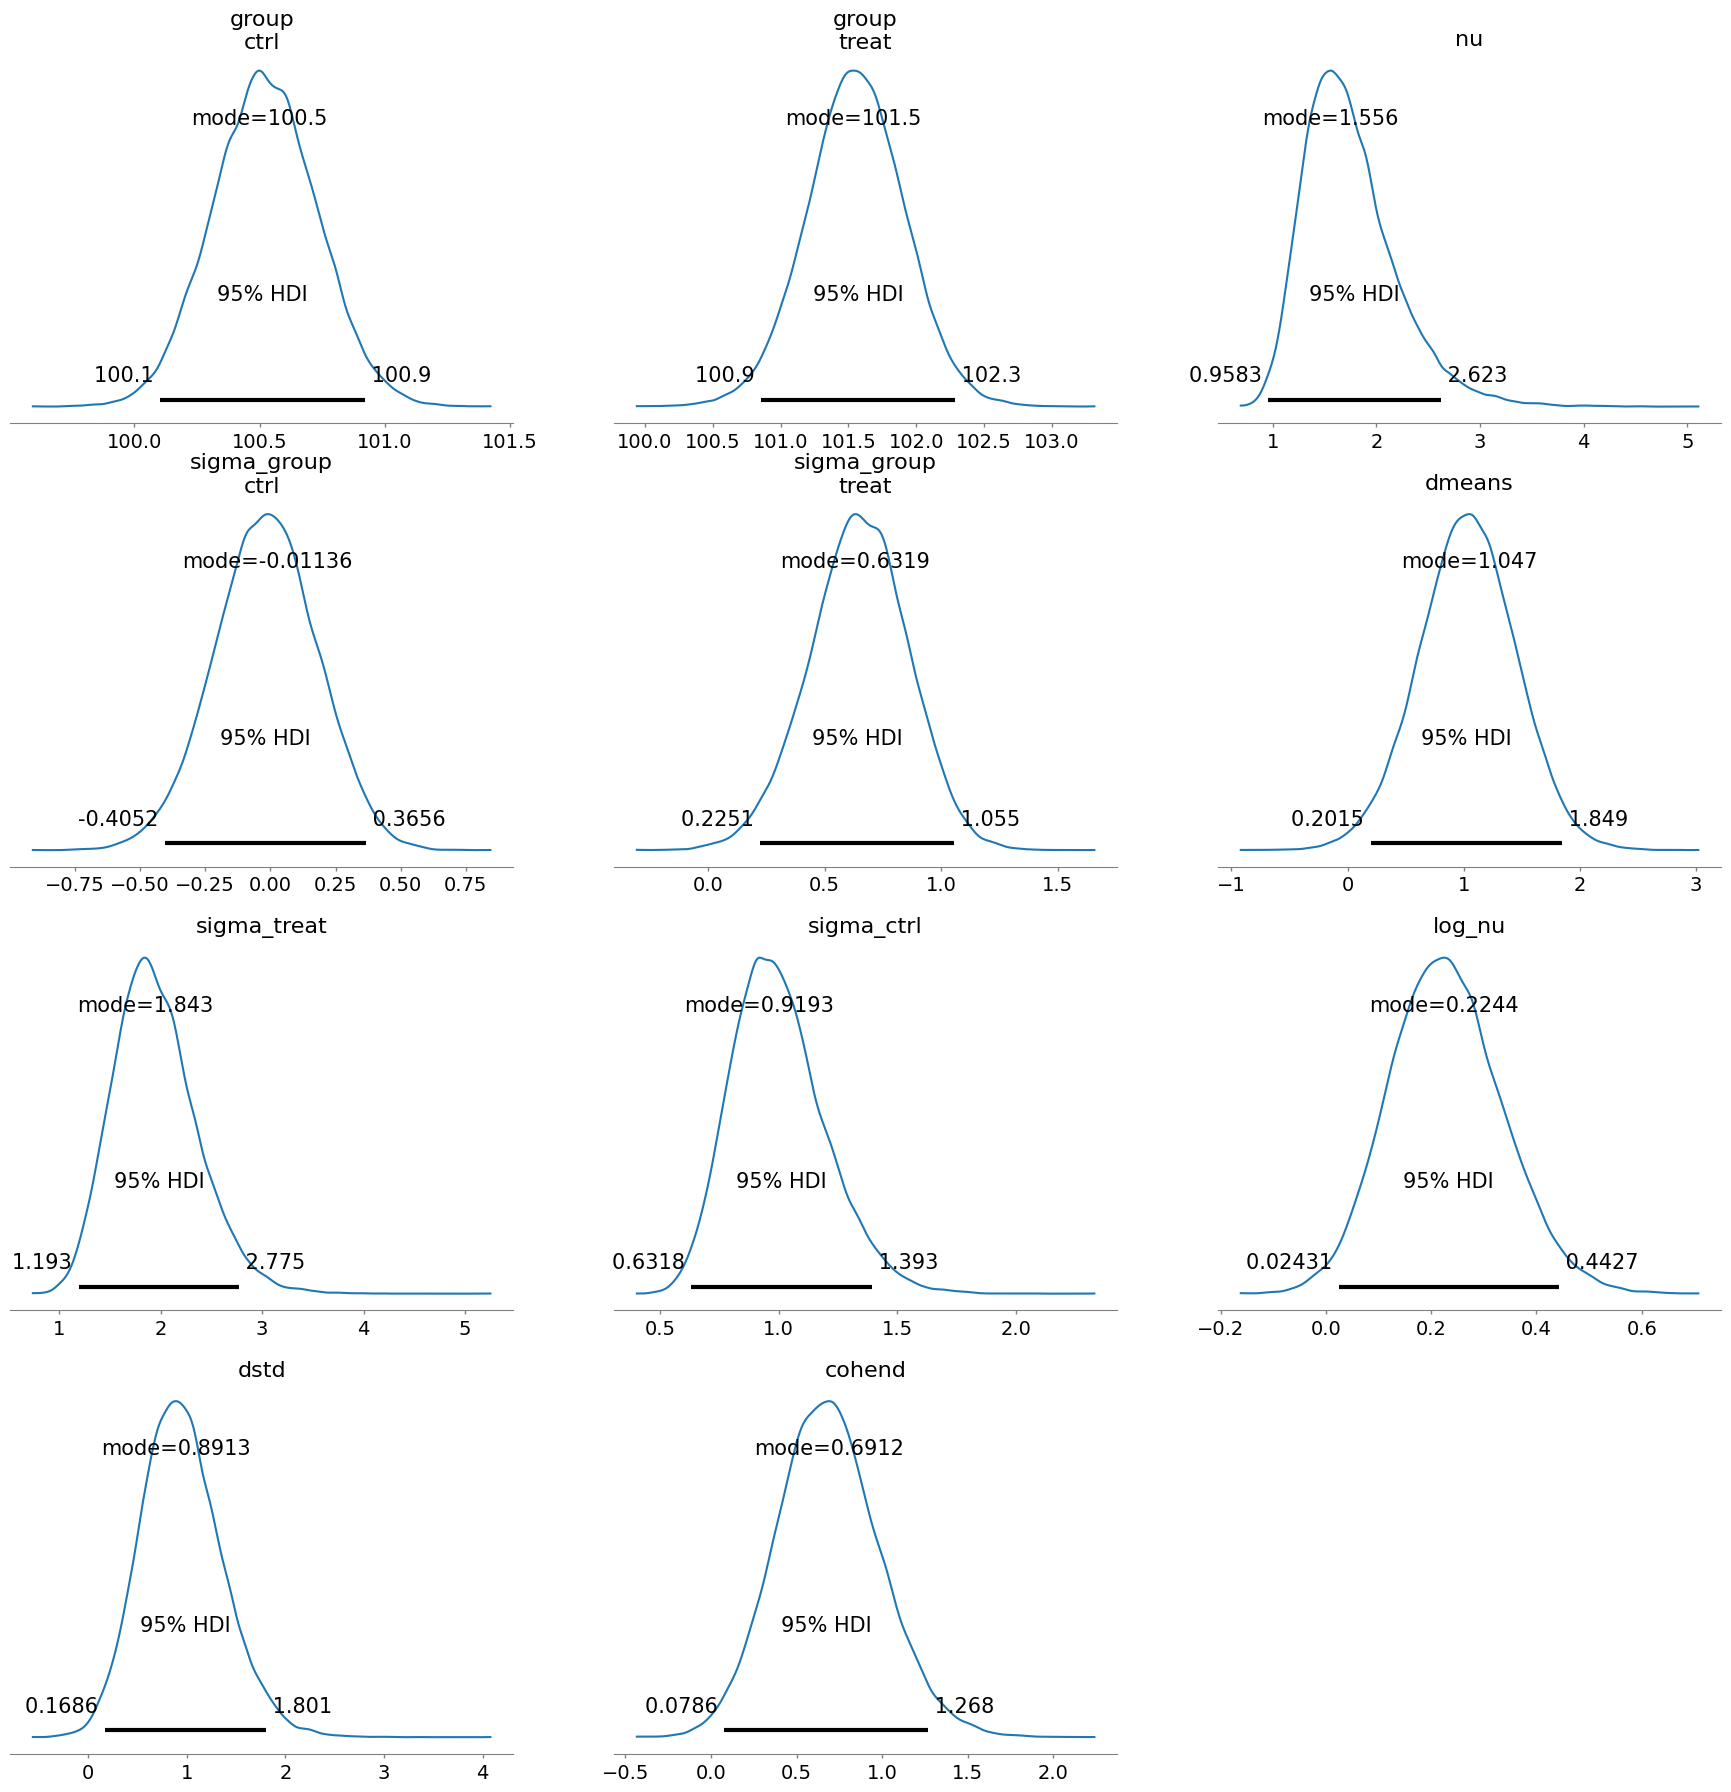

In [11]:
az.plot_posterior(idata1, round_to=4, hdi_prob=0.95, point_estimate="mode");

## BEST model from external library

In [12]:
(1/1000) ** 2 == 0.000001

True

In [13]:
import best

treated = iqs2[iqs2["group"]=="treat"]["iq"].values
controls = iqs2[iqs2["group"]=="ctrl"]["iq"].values
best_out = best.analyze_two(treated, controls, version="v1", n_samples=10000)
best_out

Using model v1 11111111111111111111111111111111111111111


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Group 1 mean, Group 2 mean, nu - 1, Group 1 sigma, Group 2 sigma]


Output()

Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 7 seconds.


In [14]:
# best.plot_all(best_out);

### BEST model 2: shifted exponential prior on nu

In [15]:
import bambi as bmb
import pymc as pm

#######################################################
formula1 = bmb.Formula("iq ~ 0 + group",
                       "sigma ~ 0 + group")


iqs_mean, iqs_std = iqs2["iq"].mean(), iqs2["iq"].std()
sigma_low = np.log(iqs_std / 1000)
sigma_up = np.log(iqs_std * 1000)

def TruncatedExponential(name, lam, *args, dims=None, **kwargs):
    exp = pm.Exponential.dist(lam=lam)
    return pm.Truncated(name, exp, lower=1, *args, dims=dims, **kwargs)

priors2 = {
    "group": bmb.Prior("Normal", mu=iqs_mean, sigma=1000*iqs_std),
    "sigma": {"group": bmb.Prior("Uniform", lower=sigma_low, upper=sigma_up)},
    "nu": bmb.Prior("TruncatedExponential", lam=1/29, dist=TruncatedExponential),
}

# Build model
mod2 = bmb.Model(formula=formula1,
                 family="t",
                 priors=priors2,
                 data=iqs2)
mod2

       Formula: iq ~ 0 + group
                sigma ~ 0 + group
        Family: t
          Link: mu = identity
                sigma = log
  Observations: 89
        Priors: 
    target = mu
        Common-level effects
            group ~ Normal(mu: 101.1798, sigma: 4744.7622)
        
        Auxiliary parameters
            nu ~ TruncatedExponential(lam: 0.0345)
    target = sigma
        Common-level effects
            sigma_group ~ Uniform(lower: -5.3507, upper: 8.4648)

In [16]:
mod2.build()
mod2.backend.model

In [17]:
#mod2.plot_priors(var_names=["nu"])

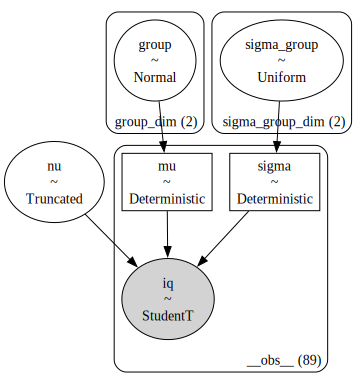

In [18]:
mod2.graph()

In [19]:
idata2 = mod2.fit(draws=10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, group, sigma_group]


Output()

Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 5 seconds.


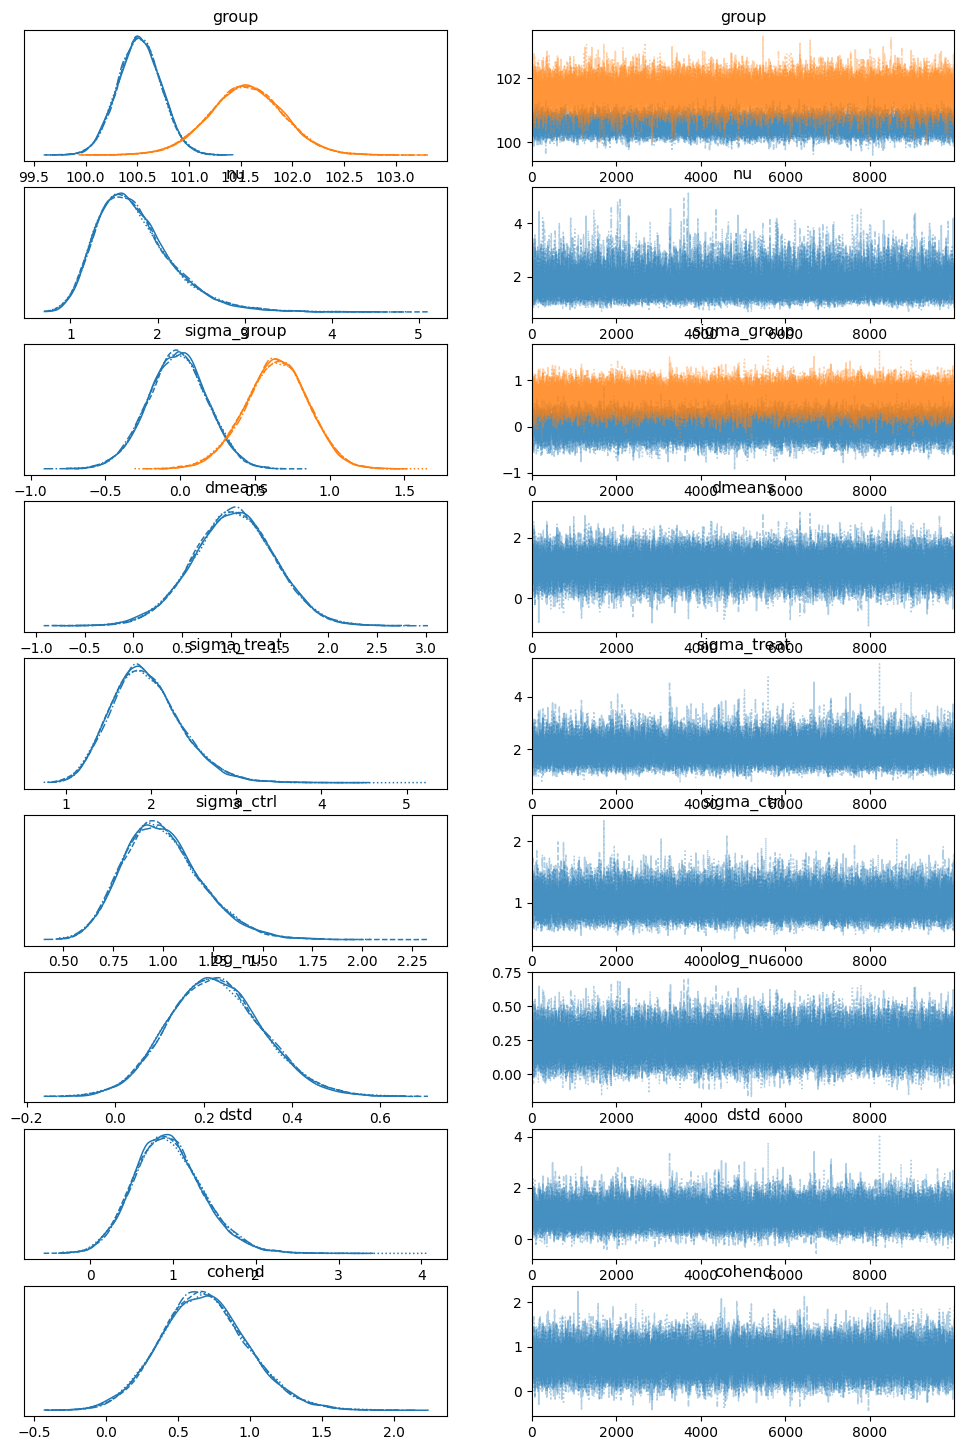

In [20]:
az.plot_trace(idata1);

In [21]:
# Calculate relevant quantities

# Difference posterior of the difference between means
post2 = idata2["posterior"]

post2_dmeans = post2["group"][:,:,1] - post1["group"][:,:,0]
# ALT. post2["group"].sel(group_dim="treat") - post2["group"].sel(group_dim="ctrl")
post2["dmeans"] = post2_dmeans

# Sigmas from log-sigmas
post2["sigma_treat"] = np.exp(post2["sigma_group"][:,:,1])
post2["sigma_ctrl"] = np.exp(post2["sigma_group"][:,:,0])

# # log-nu from nu
post2["log_nu"] = np.log10(post2["nu"])

# Difference in standard deviations
post2["dstd"] = post2["sigma_treat"] - post2["sigma_ctrl"]

# Effect size
var_pooled = (post2["sigma_treat"]**2 + post2["sigma_ctrl"]**2) / 2
post2["cohend"] = post2["dmeans"] / np.sqrt(var_pooled)

In [22]:
import arviz as az
az.summary(idata2, kind="stats", hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%
group[ctrl],100.521,0.213,100.104,100.939
group[treat],101.550,0.367,100.822,102.263
nu,1.757,0.444,1.000,2.582
sigma_group[ctrl],-0.016,0.196,-0.397,0.367
sigma_group[treat],0.649,0.211,0.236,1.061
dmeans,1.028,0.423,0.193,1.859
sigma_treat,1.956,0.414,1.206,2.787
sigma_ctrl,1.003,0.198,0.643,1.398
log_nu,0.232,0.104,0.032,0.431
dstd,0.952,0.422,0.141,1.775


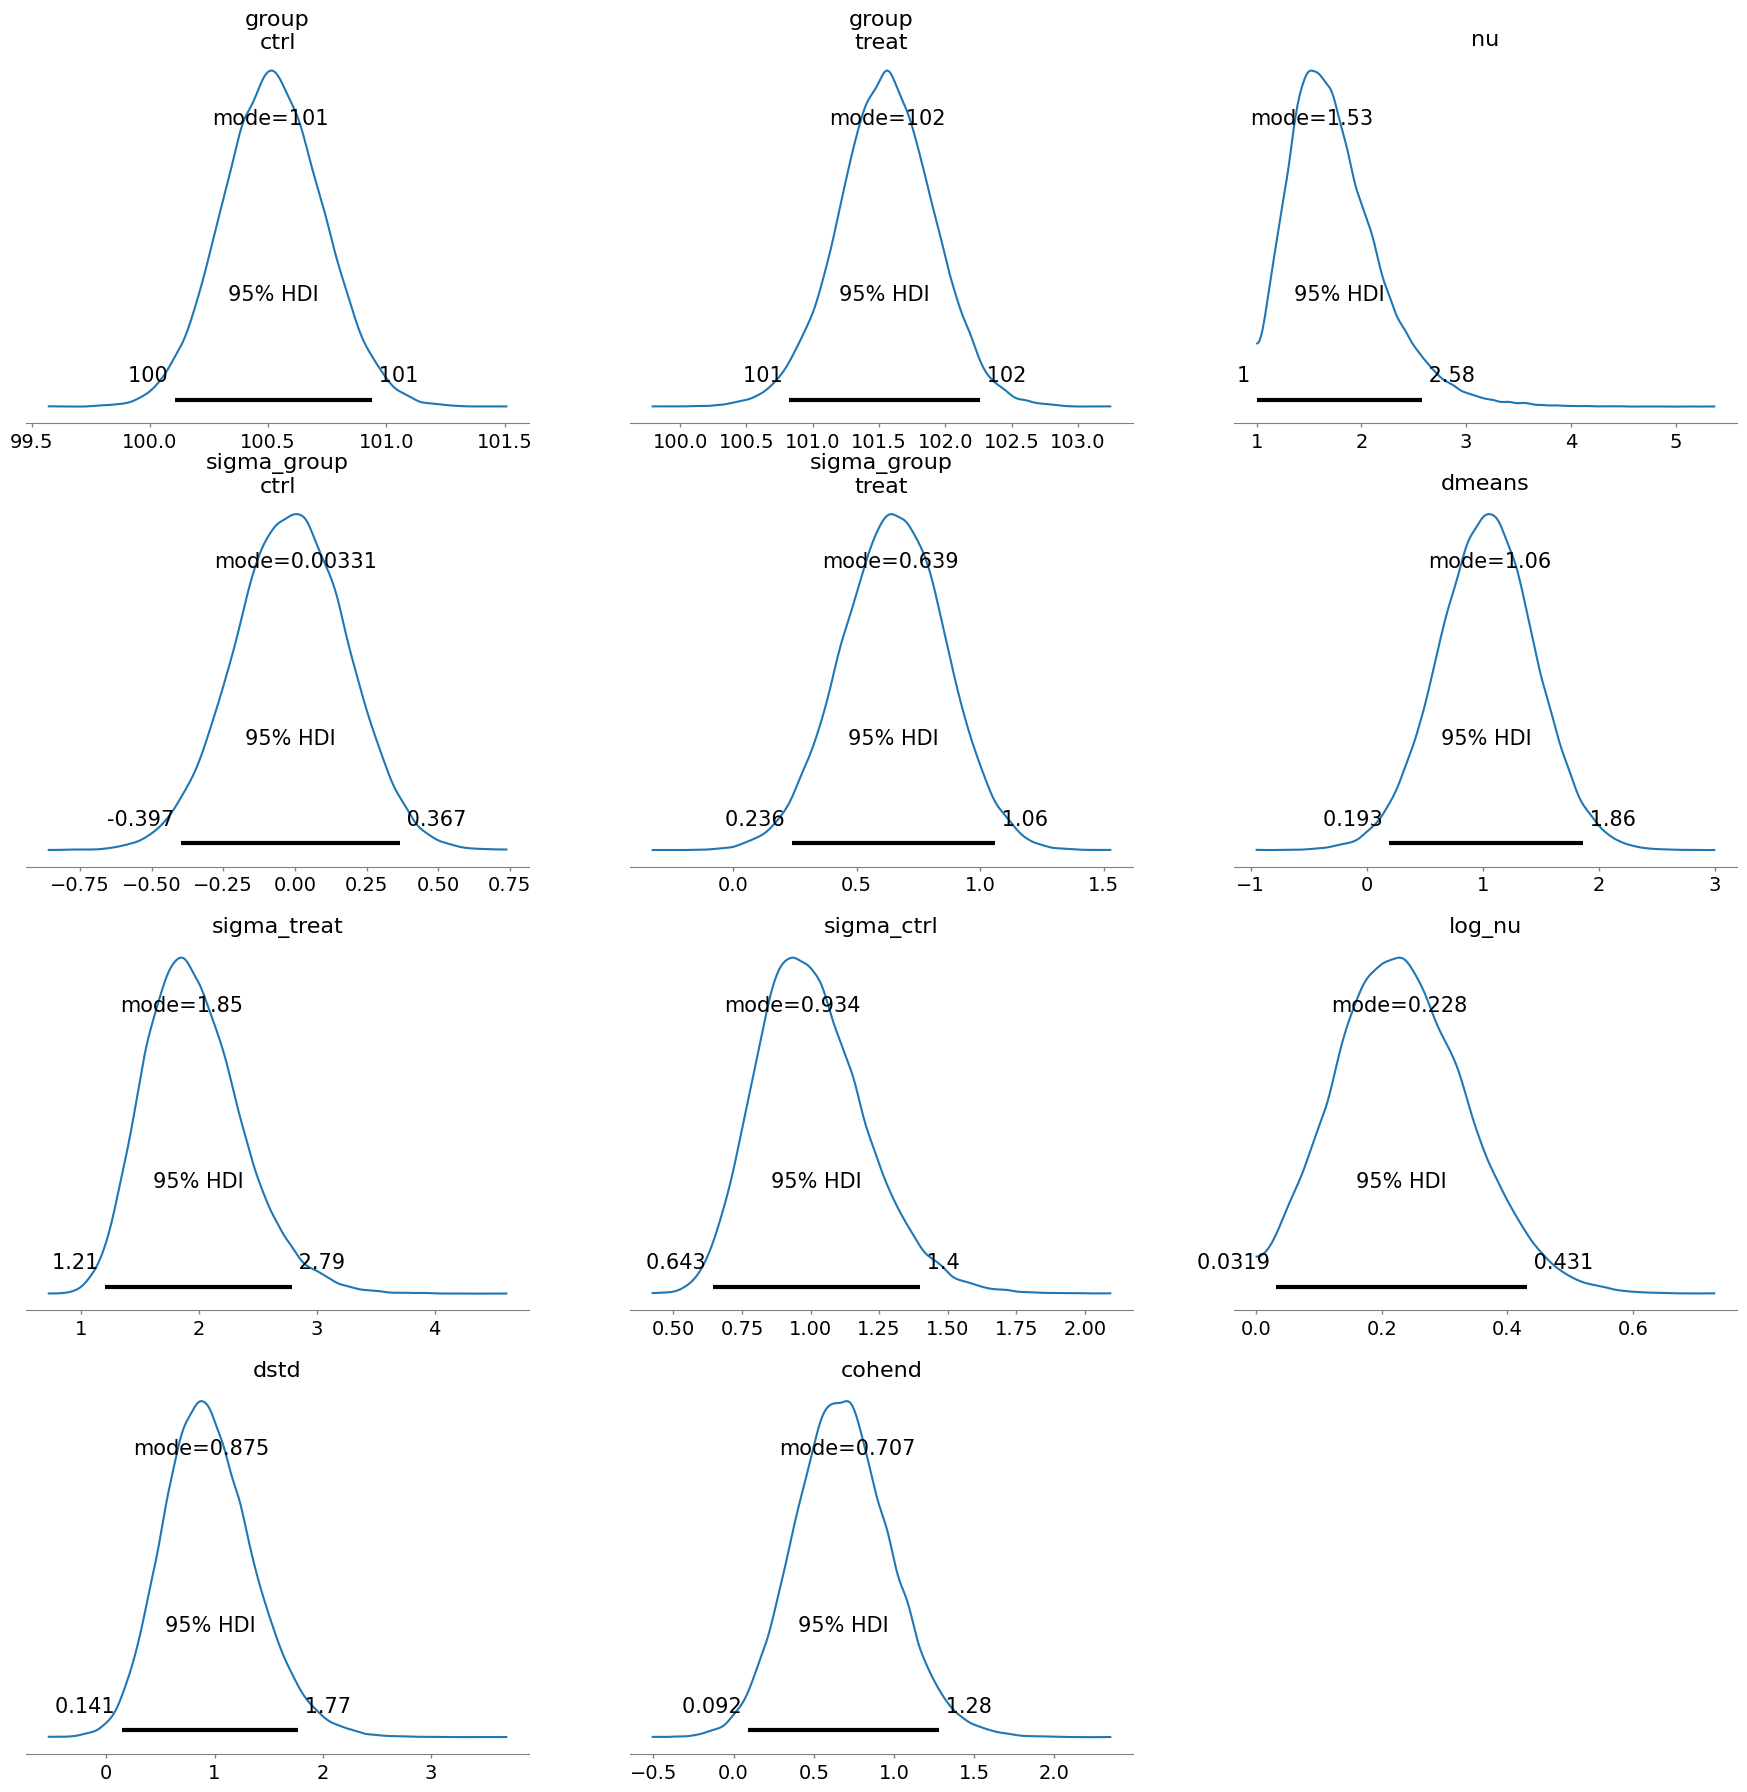

In [23]:
az.plot_posterior(idata2, round_to=3, hdi_prob=0.95, point_estimate="mode");

## Comparison

In [24]:
# az.plot_forest([idata1,idata2], model_names=["unshifted", "shifted"], combined=True,
#               var_names=["dmeans", "dstd", "cohend", "nu"])

### Other analyses

#### Equal variances t-test

In [25]:
from scipy.stats import ttest_ind

treated = iqs2[iqs2["group"]=="treat"]["iq"].values
controls = iqs2[iqs2["group"]=="ctrl"]["iq"].values

res_eqvar = ttest_ind(treated, controls, equal_var=True)
res_eqvar.statistic, res_eqvar.pvalue

(1.5586953301521096, 0.12269895509665575)

In [26]:
ci_eqvar = res_eqvar.confidence_interval(confidence_level=0.95)
[ci_eqvar.low, ci_eqvar.high]

[-0.42865302979133335, 3.5441545495481668]

#### Equivalent results using a linear model

In [27]:
import statsmodels.formula.api as smf
res_ols = smf.ols("iq ~ 1 + C(group)", data=iqs2).fit()
res_ols.tvalues["C(group)[T.treat]"], res_ols.pvalues["C(group)[T.treat]"]

(1.5586953301521327, 0.12269895509665028)

In [28]:
res_ols.conf_int().loc["C(group)[T.treat]",:].values

array([-0.42865303,  3.54415455])

#### Unequal variances t-test

In [29]:
res_uneqvar = ttest_ind(treated, controls, equal_var=False)
res_uneqvar.statistic, res_uneqvar.pvalue

(1.622190457290228, 0.10975381983712836)

In [30]:
ci_uneqvar = res_uneqvar.confidence_interval(confidence_level=0.95)
[ci_uneqvar.low, ci_uneqvar.high]

[-0.3611847716497789, 3.476686291406612]

#### Equivalent results using a linear model with unequal variances

Using generalized least squares to reproduce the unequal variance case.

In [31]:
n_t, var_t = len(treated), treated.var(ddof=1)
n_c, var_c = len(controls), controls.var(ddof=1)
sigma2s = [var_t]*n_t + [var_c]*n_c

res_gls = smf.gls("iq ~ 1 + C(group)", data=iqs2, sigma=sigma2s).fit()
res_gls.tvalues["C(group)[T.treat]"], res_gls.pvalues["C(group)[T.treat]"]

(1.622190457290225, 0.10838111883864261)

In [32]:
res_gls.conf_int().loc["C(group)[T.treat]",:].values

array([-0.35090201,  3.46640353])

#### Bayesian equal variances model

In [33]:
import bambi as bmb

mod_eqvar = bmb.Model("iq ~ 1 + group", data=iqs2)
mod_eqvar

       Formula: iq ~ 1 + group
        Family: gaussian
          Link: mu = identity
  Observations: 89
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 101.1798, sigma: 17.17)
            group ~ Normal(mu: 0.0, sigma: 23.6275)
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 4.718)

In [34]:
mod_eqvar.build()
mod_eqvar.backend.model

In [35]:
idata_eqvar = mod_eqvar.fit(draws=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, group]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.


In [36]:
import arviz as az

az.summary(idata_eqvar, kind="stats", hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%
Intercept,100.351,0.740,98.942,101.829
group[treat],1.567,1.010,-0.403,3.511
sigma,4.741,0.361,4.068,5.475


#### Bayesian unequal variances model

In [37]:
formula = bmb.Formula("iq ~ 1 + group",
                      "sigma ~ 1 + group")
mod_uneqvar = bmb.Model(formula, data=iqs2)
print(mod_uneqvar)

       Formula: iq ~ 1 + group
                sigma ~ 1 + group
        Family: gaussian
          Link: mu = identity
                sigma = log
  Observations: 89
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 101.1798, sigma: 17.17)
            group ~ Normal(mu: 0.0, sigma: 23.6275)
    target = sigma
        Common-level effects
            sigma_Intercept ~ Normal(mu: 0.0, sigma: 1.0)
            sigma_group ~ Normal(mu: 0.0, sigma: 1.0)


In [38]:
mod_uneqvar.build()
mod_uneqvar.backend.model

In [39]:
idata_uneqvar = mod_uneqvar.fit(draws=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, group, sigma_Intercept, sigma_group]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


In [40]:
az.summary(idata_uneqvar, kind="stats", hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%
Intercept,100.363,0.398,99.621,101.180
group[treat],1.548,0.988,-0.437,3.451
sigma_Intercept,0.938,0.110,0.737,1.158
sigma_group[treat],0.852,0.152,0.570,1.162


### Robust Bayesian Estimation

In [41]:
formula = bmb.Formula("iq ~ 1 + group",
                      "sigma ~ group")
mod_robust = bmb.Model(formula, family="t", data=iqs2)
print(mod_robust)

       Formula: iq ~ 1 + group
                sigma ~ group
        Family: t
          Link: mu = identity
                sigma = log
  Observations: 89
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 101.1798, sigma: 17.17)
            group ~ Normal(mu: 0.0, sigma: 23.6275)
        
        Auxiliary parameters
            nu ~ Gamma(alpha: 2.0, beta: 0.1)
    target = sigma
        Common-level effects
            sigma_Intercept ~ Normal(mu: 0.0, sigma: 1.0)
            sigma_group ~ Normal(mu: 0.0, sigma: 1.0)


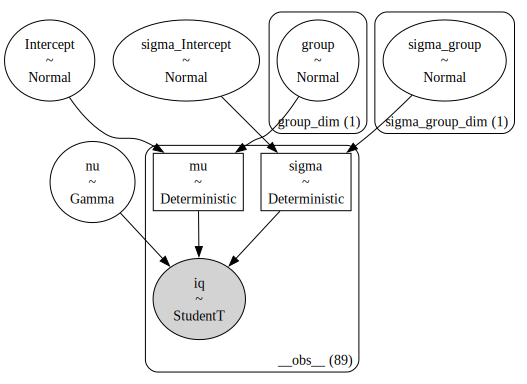

In [42]:
mod_robust.build()
# mod_robust.backend.model
mod_robust.graph()

In [43]:
idata_robust = mod_robust.fit(draws=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, Intercept, group, sigma_Intercept, sigma_group]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [44]:
az.summary(idata_robust, kind="stats", hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%
Intercept,100.528,0.213,100.090,100.921
group[treat],1.030,0.413,0.224,1.839
nu,1.812,0.468,1.017,2.710
sigma_Intercept,0.011,0.195,-0.360,0.396
sigma_group[treat],0.619,0.249,0.142,1.113


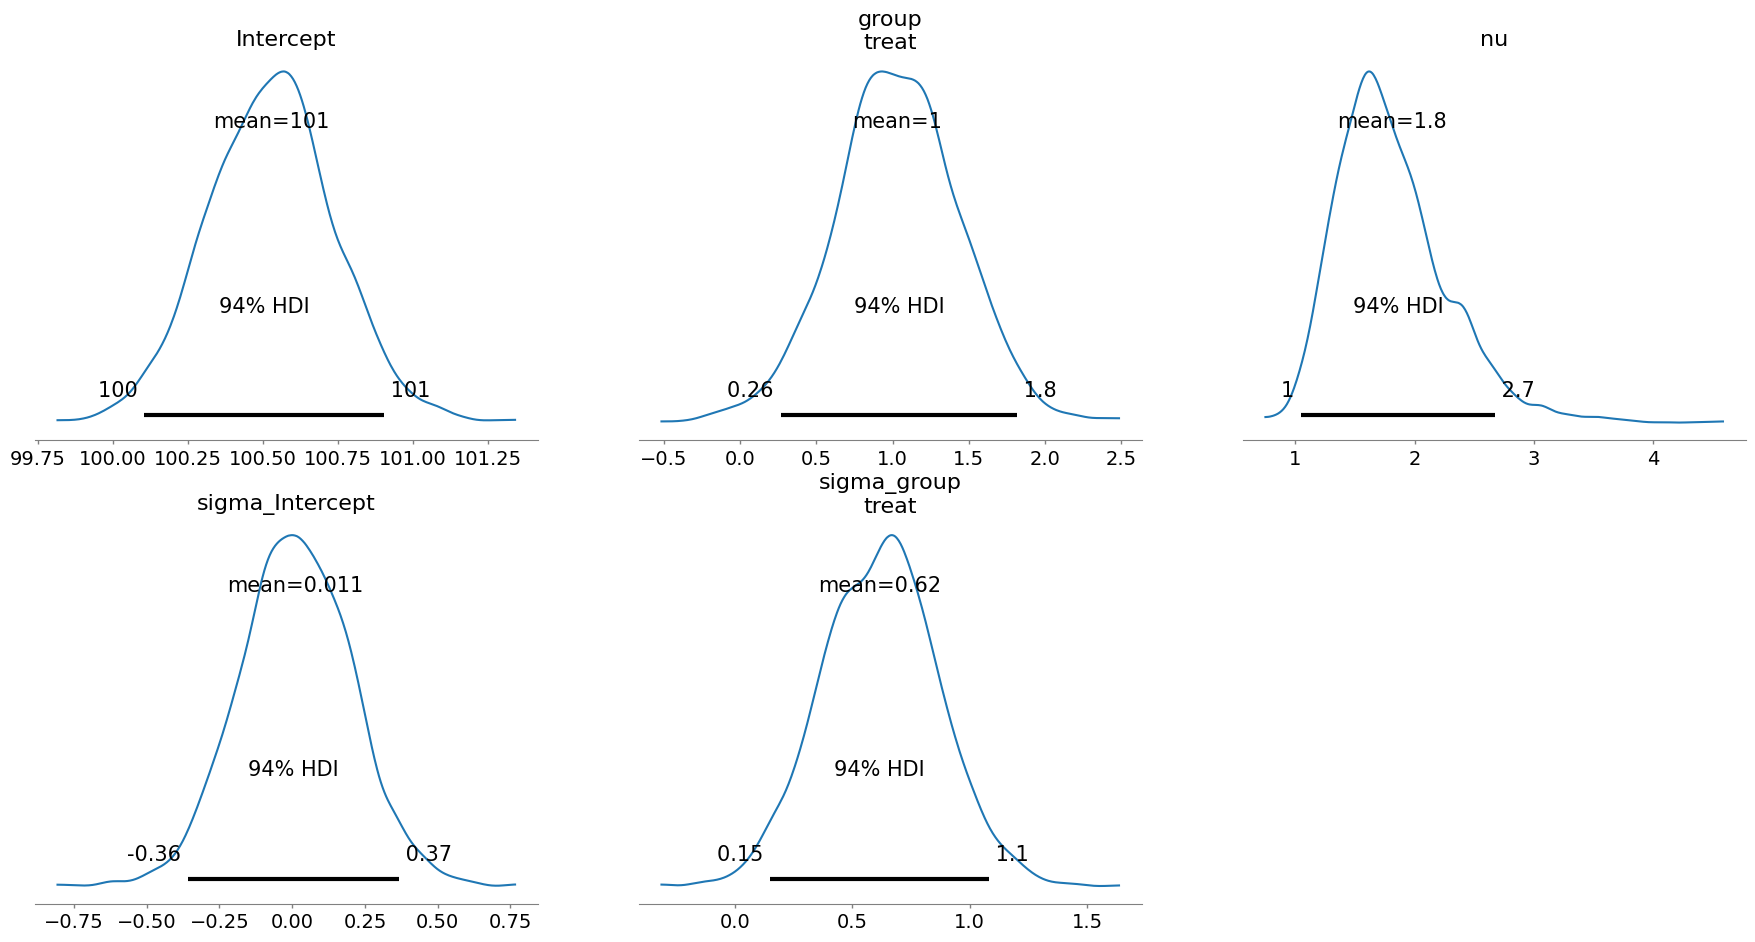

In [45]:
az.plot_posterior(idata_robust);

In [46]:
# p-value
postD = idata_robust["posterior"]["group"][0].values.flatten()
np.sum(postD < 0) / len(postD)

0.008

In [47]:
# from scipy.stats import expon
# rvE = expon(scale=29, loc=1)
# xs = np.linspace(0, 200 ,1000)
# sns.lineplot(x=xs, y=rvE.pdf(xs))

### Robust Bayesian estimation without intercept

In [48]:
5*np.sqrt((np.var(treated,ddof=1) + np.var(controls,ddof=1))/2)

23.072229417477242

In [49]:
5*iqs2["iq"].std(ddof=0)

23.590154556423748

In [50]:
formula = bmb.Formula("iq ~ 0 + group",
                      "sigma ~ 0 + group")
mod_robust2 = bmb.Model(formula, family="t", data=iqs2)
print(mod_robust2)

       Formula: iq ~ 0 + group
                sigma ~ 0 + group
        Family: t
          Link: mu = identity
                sigma = log
  Observations: 89
        Priors: 
    target = mu
        Common-level effects
            group ~ Normal(mu: [0. 0.], sigma: [23.6275 23.6275])
        
        Auxiliary parameters
            nu ~ Gamma(alpha: 2.0, beta: 0.1)
    target = sigma
        Common-level effects
            sigma_group ~ Normal(mu: 0.0, sigma: 1.0)


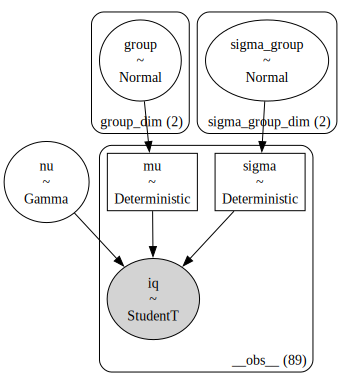

In [51]:
mod_robust2.build()
# mod_robust2.backend.model
mod_robust2.graph()

In [52]:
idata_robust2 = mod_robust2.fit(draws=2000)

post_robust2 = idata_robust2["posterior"]
dmeans_robust2 = post_robust2["group"][:,:,1] - post_robust2["group"][:,:,0]
# ALT. post_robust2["group"].sel(group_dim="treat") - post_robust2["group"].sel(group_dim="ctrl")
post_robust2["dmeans"] = dmeans_robust2

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, group, sigma_group]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


In [53]:
az.summary(idata_robust2, kind="stats", hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%
group[ctrl],100.511,0.208,100.104,100.916
group[treat],101.527,0.367,100.794,102.238
nu,1.802,0.463,0.970,2.688
sigma_group[ctrl],-0.012,0.191,-0.395,0.355
sigma_group[treat],0.636,0.205,0.219,1.030
dmeans,1.016,0.421,0.226,1.873


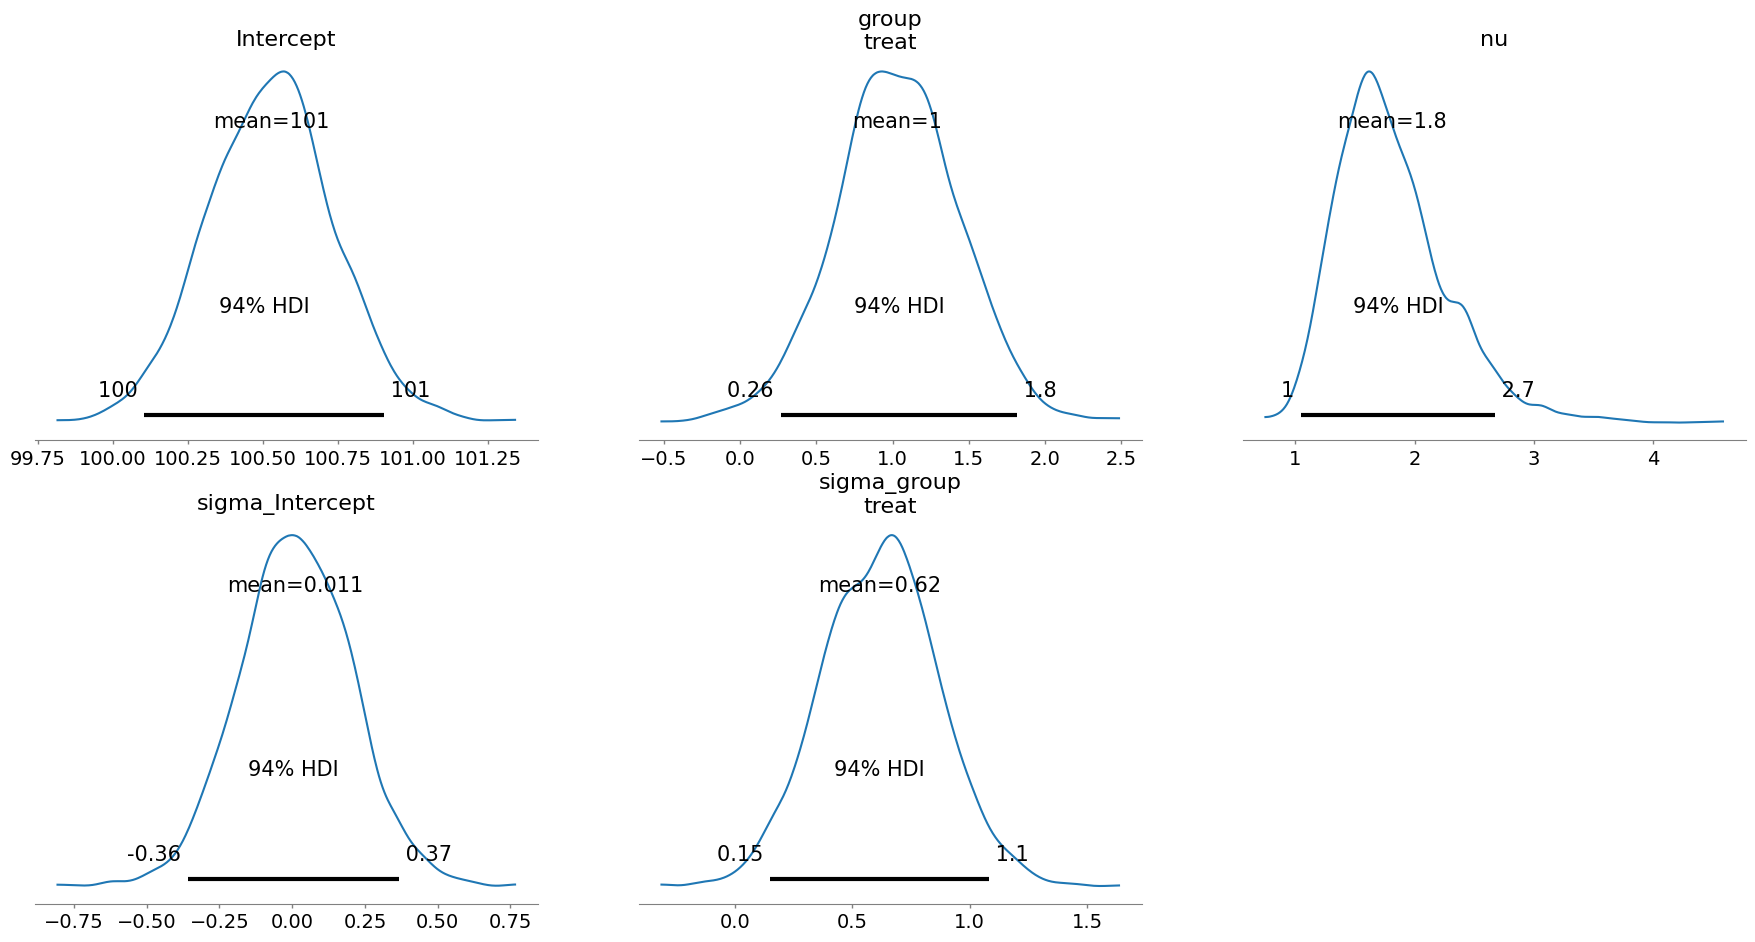

In [54]:
az.plot_posterior(idata_robust);